In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

2024-02-26 10:41:11.936596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 10:41:12.514455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-02-26 10:41:14.474143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 10:41:14.500926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 10:41:14.501206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
IMAGE_SHAPE = (5, 64, 64)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_validation.hdf5'
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5'

In [6]:
# param_names = []
# for i in ['g', 'r', 'i', 'z', 'y']:
#     for j in ['cmodel_mag', 'isophotal_area', 'half_light_radius', 'major_axis', 'minor_axis', 'ellipticity', 'sersic_index', 'peak_surface_brightness']:
#         param_names.append(i + '_' + j)
# v17

param_names = []
for i in ['g', 'r', 'i', 'z', 'y']:
    for j in ['cmodel_mag']:
        param_names.append(i + '_' + j)
        # v19

In [7]:
gen_args = {
    'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': hparams['batch_size'],
    'shuffle': False}

train_gen = HDF5ImageGenerator(TRAIN_PATH, mode = 'train', **gen_args)
val_gen = HDF5ImageGenerator(VAL_PATH, mode = 'train', **gen_args)
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)

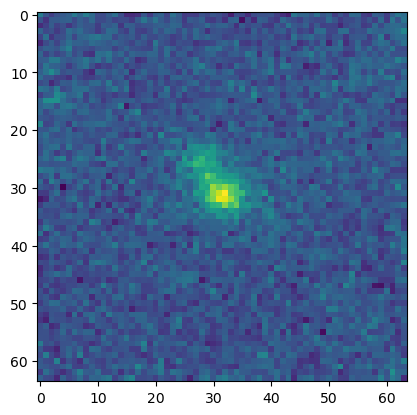

In [8]:
plt.imshow(test_gen[0][0][18][0])

In [9]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [10]:
input_cnn = Input(shape=(5,64,64))
# input_nn = Input(shape=(len(param_names),)) # don't forget to change this

# CNN
conv1 = Conv2D(32, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv1)
conv2 = Conv2D(64, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv2)
conv3 = Conv2D(128, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv3)
conv4 = Conv2D(256, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv4)
conv5 = Conv2D(256, kernel_size = (3, 3), activation = 'tanh', padding = 'same', data_format = 'channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format = 'channels_first')(conv5)
conv6 = Conv2D(512, kernel_size = (3, 3),activation = 'relu', padding = 'same', data_format = 'channels_first')(pool5)
conv7 = Conv2D(512, kernel_size = (3, 3),activation = 'relu', padding = 'same', data_format = 'channels_first')(conv6)
flatten = GlobalMaxPooling2D(data_format = 'channels_first')(conv7)
dense1 = Dense(512, activation = 'tanh')(flatten)
dense2 = Dense(128, activation = 'tanh')(dense1)
dense3 = Dense(32, activation = 'tanh')(dense2)

# NN
# hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
# hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
# hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
# hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
# hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
# hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)

# Concat & Output
# concat = Concatenate()([dense3, hidden6])
output = Dense(1)(dense3)
model = Model(inputs=[input_cnn], outputs=[output])

input_cnn = Input(shape=(5,64,64))

# CNN
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', strides=(2, 2), data_format='channels_first')(conv2)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(conv3)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', strides=(2, 2), data_format='channels_first')(conv4)
conv6 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(conv5)
conv7 = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = GlobalMaxPooling2D(data_format='channels_first')(conv7)

# Dense layers
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

# Output
output = Dense(1)(dense3)
model = Model(inputs=[input_cnn], outputs=[output])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 64, 64)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 64)        1472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 32)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 16, 16)       73856 

In [12]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

model.fit(train_gen, batch_size=hparams['batch_size'], epochs=10, shuffle=True, verbose=1, validation_data=val_gen, callbacks=[])

In [13]:
model.load_weights('/data3/Billy/cnn_saved_weights')

# might take too much memory, use PCA on morphology

2/8 [======>.......................] - ETA: 0s

2024-02-26 10:43:03.779475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 33ms/step


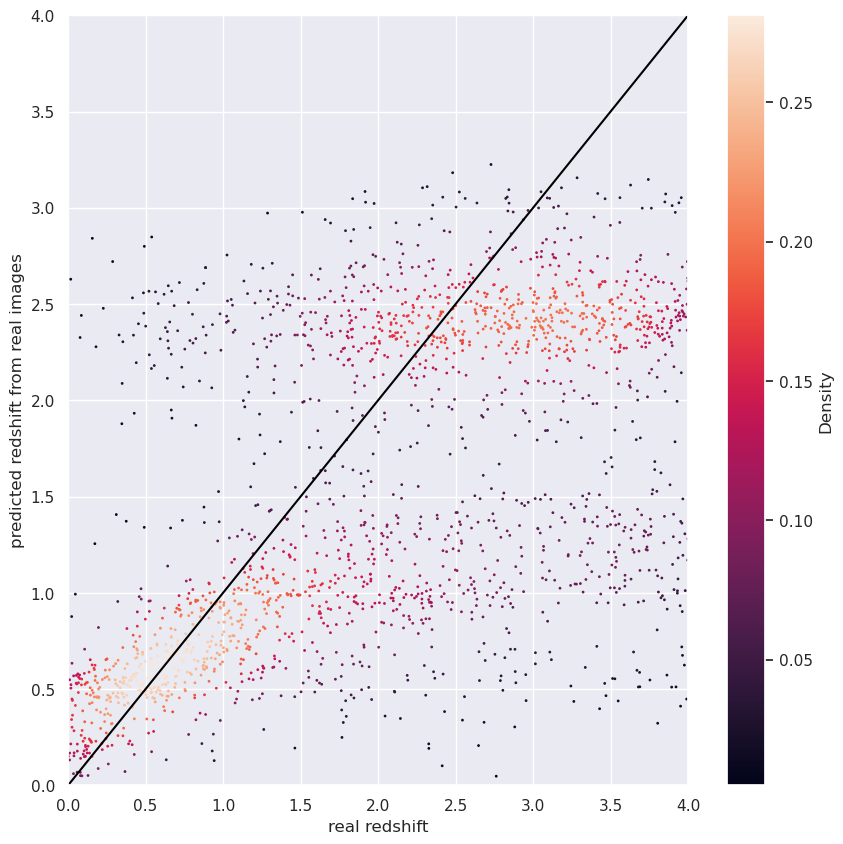

4/8 [==============>...............] - ETA: 0s

2024-02-26 10:43:04.584895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 29ms/step


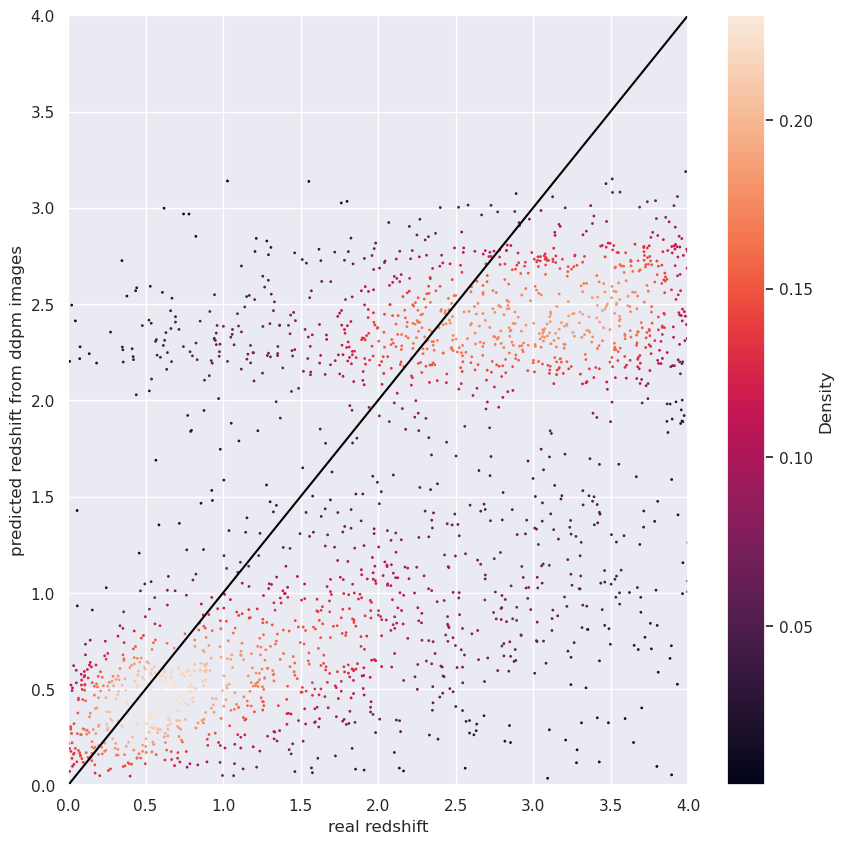

4/8 [==============>...............] - ETA: 0s

2024-02-26 10:43:05.203022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 29ms/step


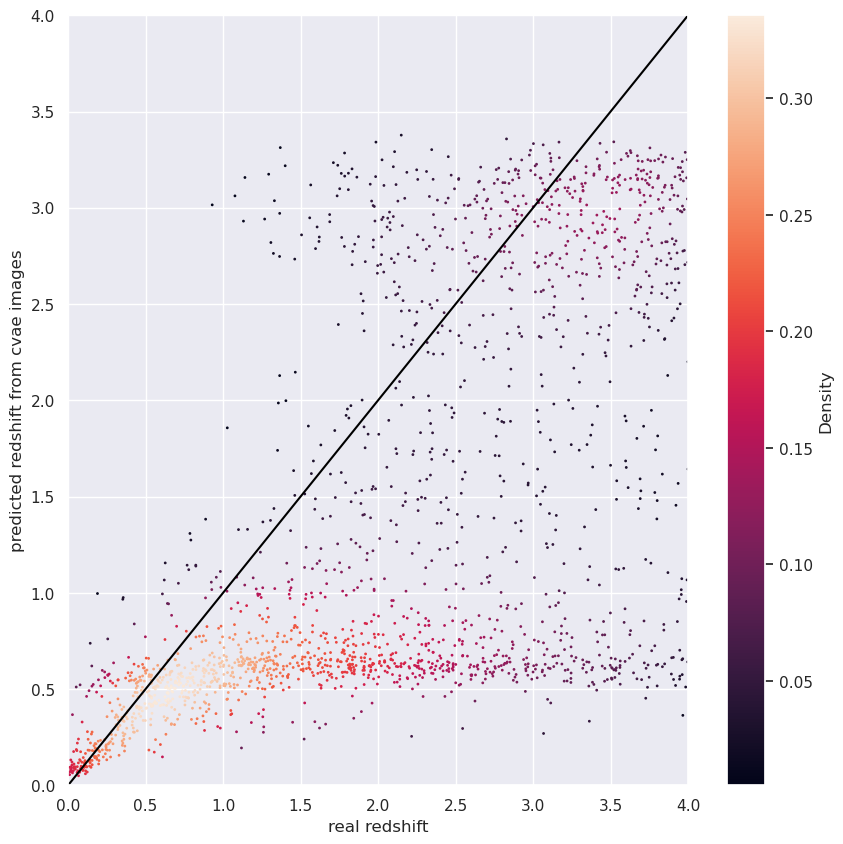

In [21]:
TEST_PATH = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_small.hdf5'
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm_extended/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred_real = model.predict(test_gen)



with h5py.File(TEST_PATH, 'r') as file:
    y_test_real = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])
    
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_real, pred_real[:,0]])).astype('float32')
z_real = gaussian_kde(xy)(xy)

import seaborn as sns
z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_real, pred_real[:,0], c = z_real, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
# plt.title('Prediction')
plt.xlabel('real redshift')
plt.ylabel('predicted redshift from real images')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

metrics_real = get_point_metrics(pd.Series(np.ravel(pred_real)), pd.Series(y_test_real), binned=False)

# metrics_real

TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred_ddpm = model.predict(test_gen)

with h5py.File(TEST_PATH, 'r') as file:
    y_test_ddpm = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])
    
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_ddpm, pred_ddpm[:,0]])).astype('float32')
z_ddpm = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_ddpm, pred_ddpm[:,0], c = z_ddpm, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
# plt.title('Prediction')
plt.xlabel('real redshift')
plt.ylabel('predicted redshift from ddpm images')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

metrics_ddpm = get_point_metrics(pd.Series(np.ravel(pred_ddpm)), pd.Series(y_test_ddpm), binned=False)

TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/cvae/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred_cvae = model.predict(test_gen)
with h5py.File(TEST_PATH, 'r') as file:
    y_test_cvae = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])
    
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_cvae, pred_cvae[:,0]])).astype('float32')
z_cvae = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_cvae, pred_cvae[:,0], c = z_cvae, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
# plt.title('Prediction')
plt.xlabel('real redshift')
plt.ylabel('predicted redshift from cvae images')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

metrics_cvae = get_point_metrics(pd.Series(np.ravel(pred_cvae)), pd.Series(y_test_cvae), binned=False)

8/8 [==============================] - 0s 13ms/step


2024-02-26 10:41:20.490414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/8 [==>...........................] - ETA: 0s

2024-02-26 10:41:20.918506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/8 [======>.......................] - ETA: 0s

2024-02-26 10:41:22.344462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 34ms/step


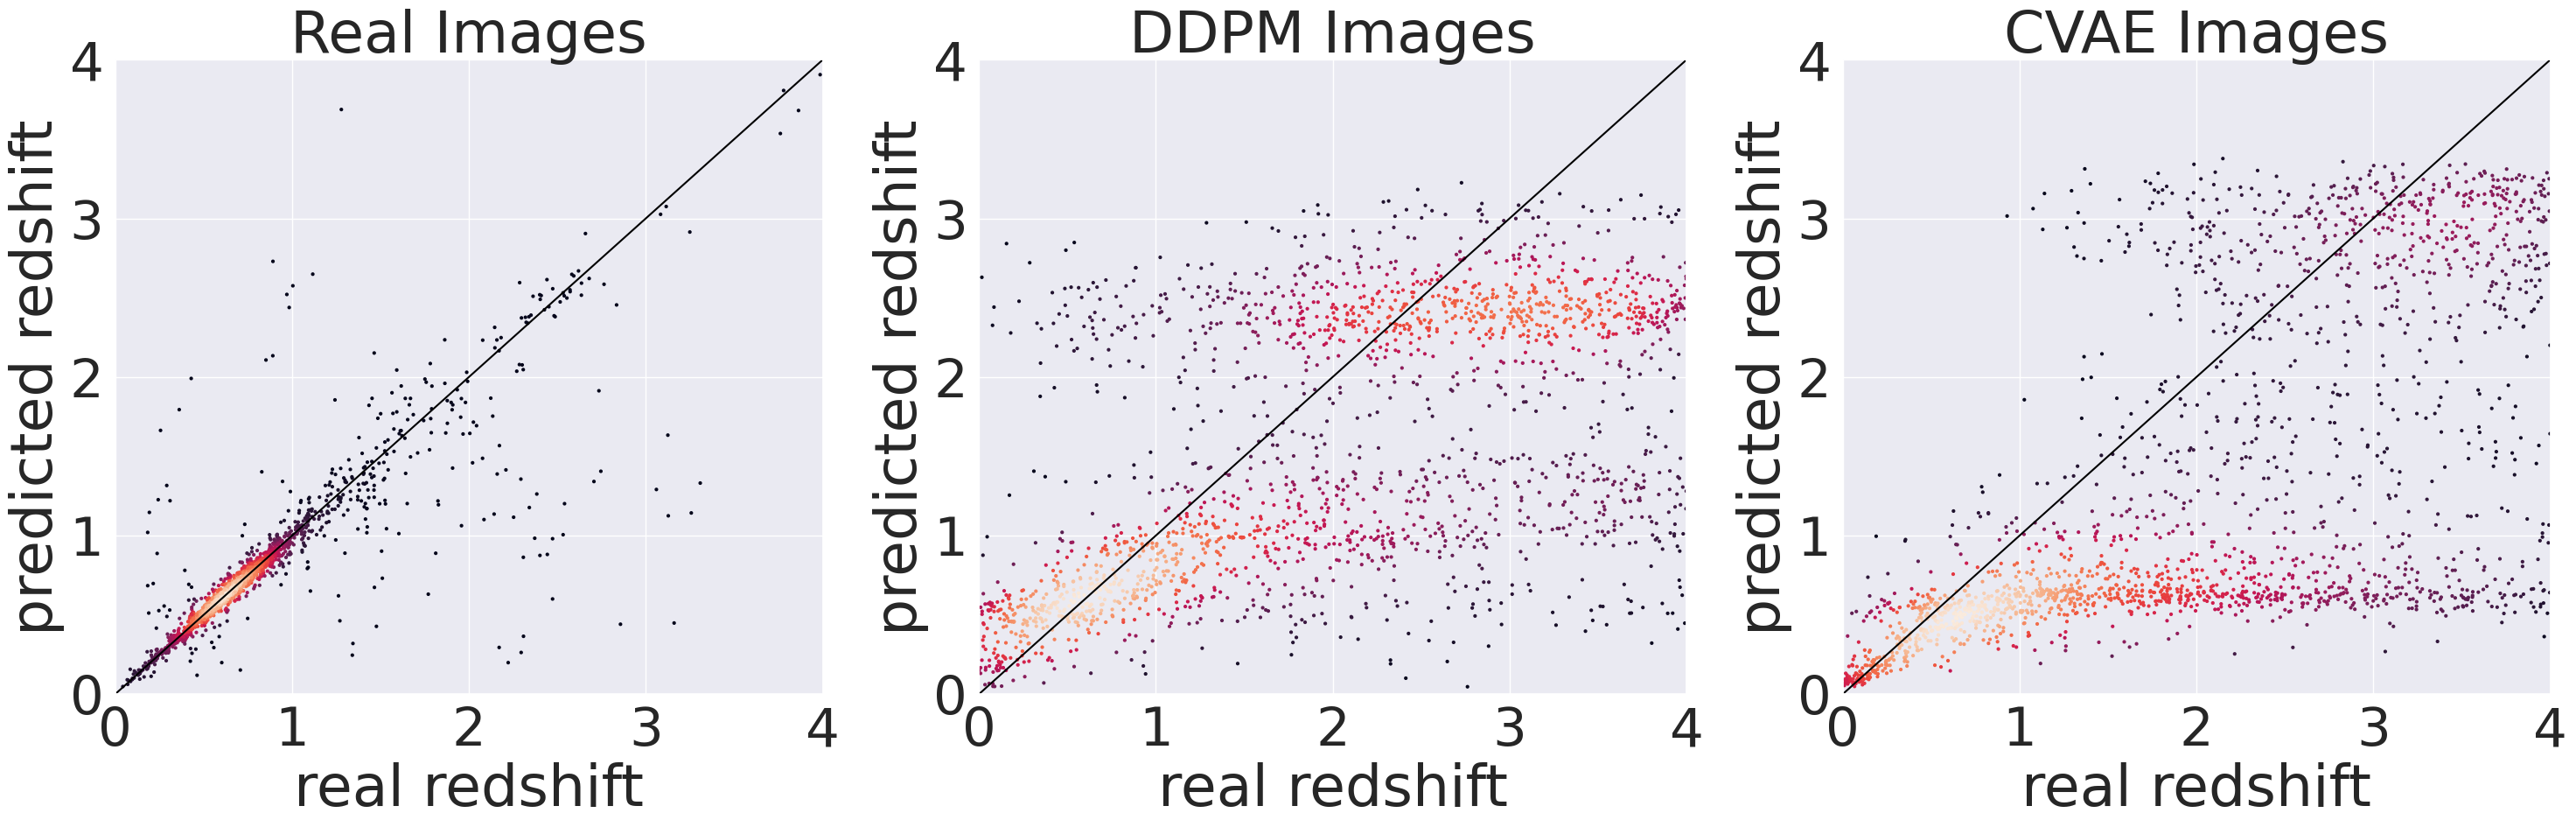

'redshift_prediction_plots.png'

In [15]:
path_real = f'/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_small.hdf5'
path_ddpm = f'/data/HSC_generated/HSC_generated_v1/ddpm_extended/64x64/5x64x64_testing.hdf5'
path_cvae = f'/data/HSC_generated/HSC_generated_v1/cvae/64x64/5x64x64_testing.hdf5'

# Function to load data and generate predictions
def load_and_predict(TEST_PATH):
    test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
    pred = model.predict(test_gen)
    with h5py.File(TEST_PATH, 'r') as file:
        y_test = np.asarray(file['specz_redshift'][:])
    return y_test, pred

y_test_real, pred_real = load_and_predict(path_real)
y_test_ddpm, pred_ddpm = load_and_predict(path_ddpm)
y_test_cvae, pred_cvae = load_and_predict(path_cvae)

# Function to create a scatter plot
def create_scatter_plot(y_test, pred, title):
    xy = np.vstack([y_test, pred[:,0]]).astype('float32')
    z = gaussian_kde(xy)(xy)
    z_max = 4
    ax.scatter(y_test, pred[:,0], c=z, s=4, edgecolor=None)
    ax.plot([0, z_max], [0, z_max], color='black')
    ax.set_xlim([0, z_max])
    ax.set_ylim([0, z_max])
    ax.set_xlabel('real redshift')
    ax.set_ylabel('predicted redshift')
    ax.set_title(title)

# Create a figure with 3 subplots
sns.set(rc={'figure.figsize': (30, 10), 'lines.markersize': 40})
sns.set(font_scale=4)
plt.rcParams.update({'font.size': 25})
fig, axes = plt.subplots(1, 3)

# Plot each scatter plot in a subplot
ax = axes[0]
create_scatter_plot(y_test_real, pred_real, 'Real Images')
ax = axes[1]
create_scatter_plot(y_test_ddpm, pred_ddpm, 'DDPM Images')
ax = axes[2]
create_scatter_plot(y_test_cvae, pred_cvae, 'CVAE Images')

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

# Save the figure as a PNG file
output_path = 'redshift_prediction_plots.png'
fig.savefig(output_path)

output_path


In [16]:
metrics_real

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.071788,-0.000202,-0.000982,0.025607,0.021937,0.143,0.048,0.067524


In [17]:
metrics_cvae

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.585067,-0.201758,-0.182593,0.264098,0.266734,0.03,0.6355,1.427359


In [18]:
metrics_ddpm

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.62322,-0.171519,-0.173532,0.287997,0.26306,0.0745,0.702,1.226954


In [19]:
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/ddpm_extended/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred_ddpm = model.predict(test_gen)

1/8 [==>...........................] - ETA: 0s

2024-01-31 19:07:55.726522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 2s 214ms/step


In [20]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test_ddpm = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])

In [21]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_ddpm, pred_ddpm[:,0]])).astype('float32')
z_ddpm = gaussian_kde(xy)(xy)

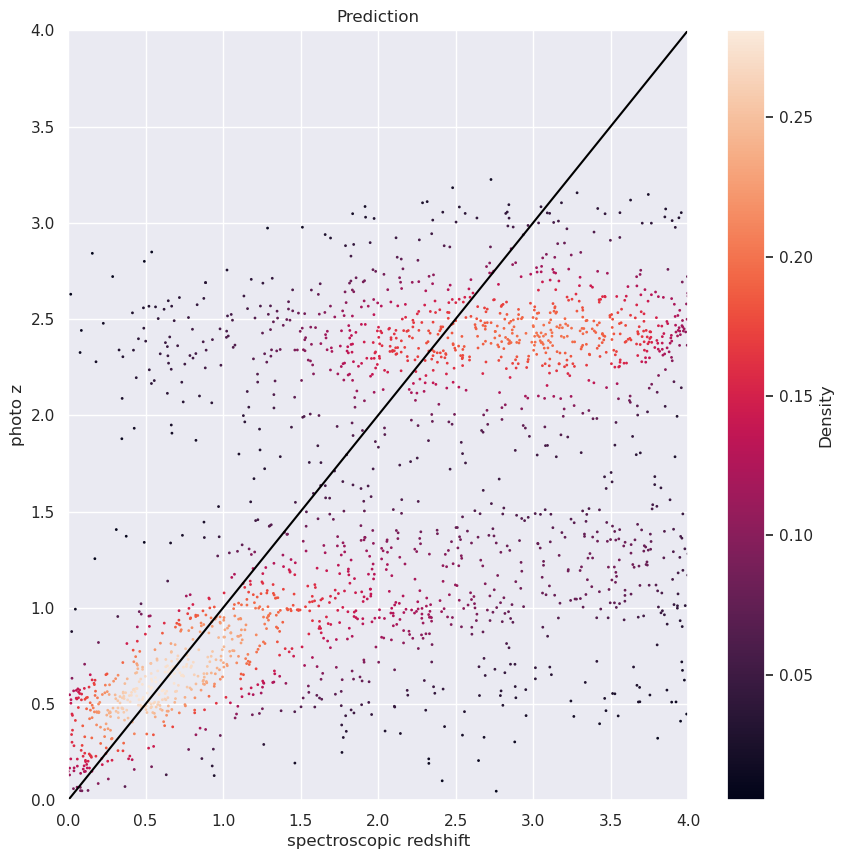

In [22]:
import seaborn as sns
z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_ddpm, pred_ddpm[:,0], c = z_ddpm, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [23]:
metrics_ddpm = get_point_metrics(pd.Series(np.ravel(pred_ddpm)), pd.Series(y_test_ddpm), binned=False)

In [24]:
metrics_ddpm

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.582112,-0.130213,-0.123373,0.287694,0.269219,0.063,0.637,1.232453


3/8 [==========>...................] - ETA: 0s

2024-01-31 19:07:57.766080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 0s 28ms/step


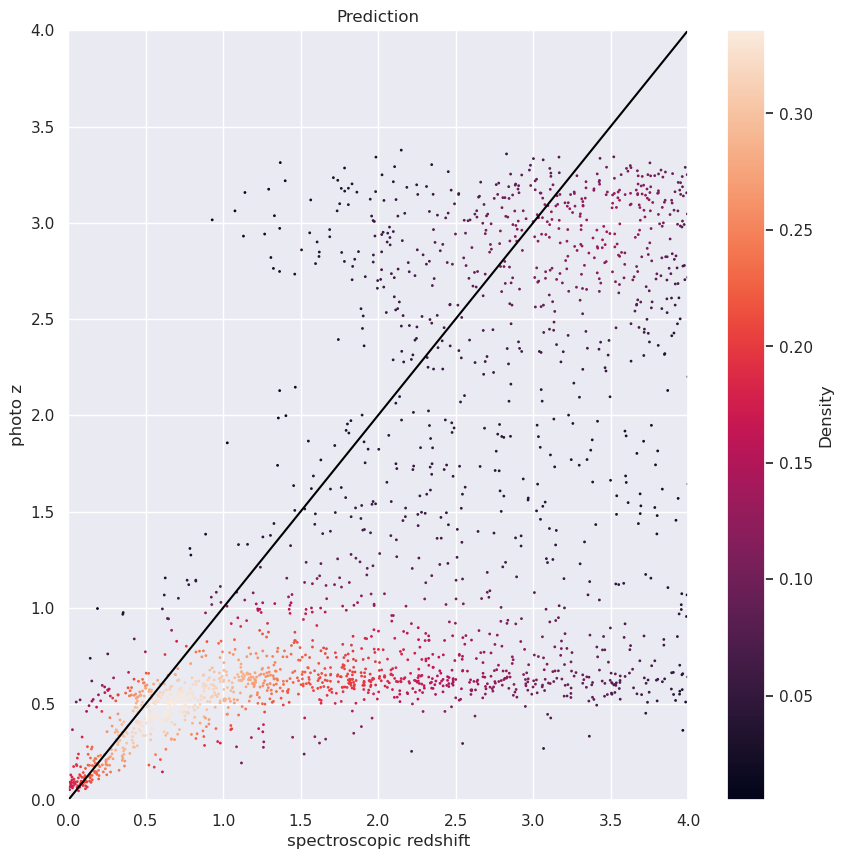

In [25]:
TEST_PATH = f'/data/HSC_generated/HSC_generated_v1/cvae/64x64/5x64x64_testing.hdf5'
test_gen = HDF5ImageGenerator(TEST_PATH, mode = 'train', **gen_args)
pred_cvae = model.predict(test_gen)
with h5py.File(TEST_PATH, 'r') as file:
    y_test_cvae = np.asarray(file['specz_redshift'][:])
    # oid_test = np.asarray(file['object_id'][:])
    
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_cvae, pred_cvae[:,0]])).astype('float32')
z_cvae = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_cvae, pred_cvae[:,0], c = z_cvae, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])
plt.show()

In [26]:
metrics_cvae = get_point_metrics(pd.Series(np.ravel(pred_cvae)), pd.Series(y_test_cvae), binned=False)

In [27]:
metrics_cvae

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.585067,-0.201758,-0.182593,0.264098,0.266734,0.03,0.6355,1.427359


In [28]:
metrics_ddpm

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.582112,-0.130213,-0.123373,0.287694,0.269219,0.063,0.637,1.232453


In [29]:
def calculate_loss_individual(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = z_photo - z_spec
    gamma = 0.15
    denominator = 1.0 + (dz/gamma) ** 2
    loss = 1 - 1.0 / denominator
    return loss

In [30]:
calculate_loss_individual(pred_cvae[:,0], y_test_cvae)

array([0.99031459, 0.99584301, 0.99365194, ..., 0.23240039, 0.99430166,
       0.95545837])

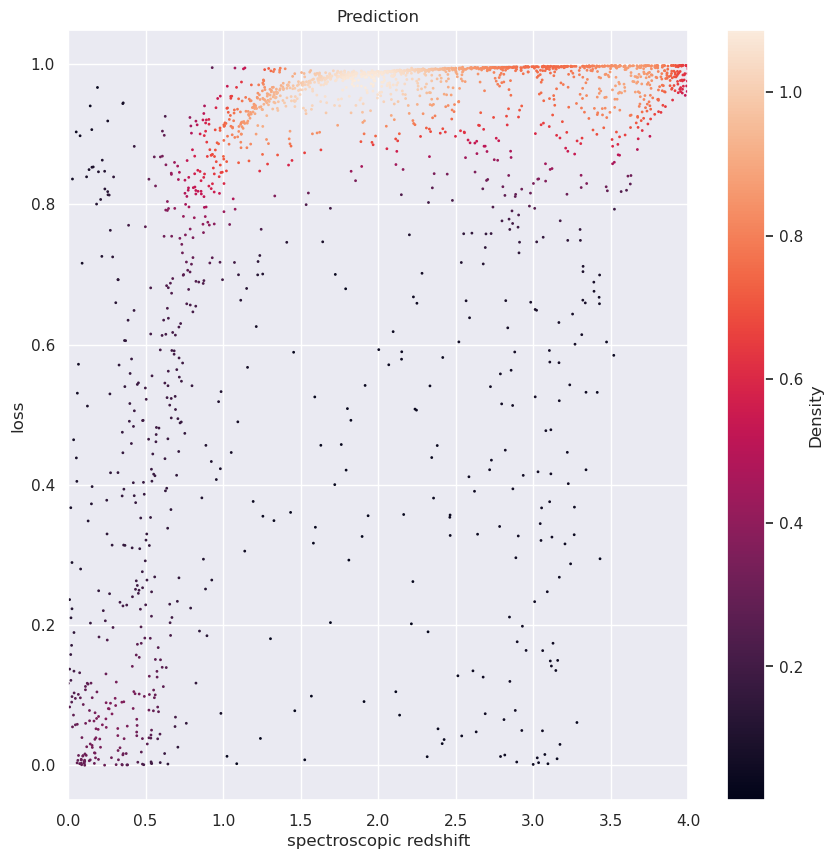

In [31]:
loss_array_cvae = calculate_loss_individual(pred_cvae[:,0], y_test_cvae)


from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_cvae, loss_array_cvae])).astype('float32')
z_loss_cvae = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_cvae, loss_array_cvae, c = z_loss_cvae, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('loss')
# plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
# plt.ylim([0, z_max])
plt.show()

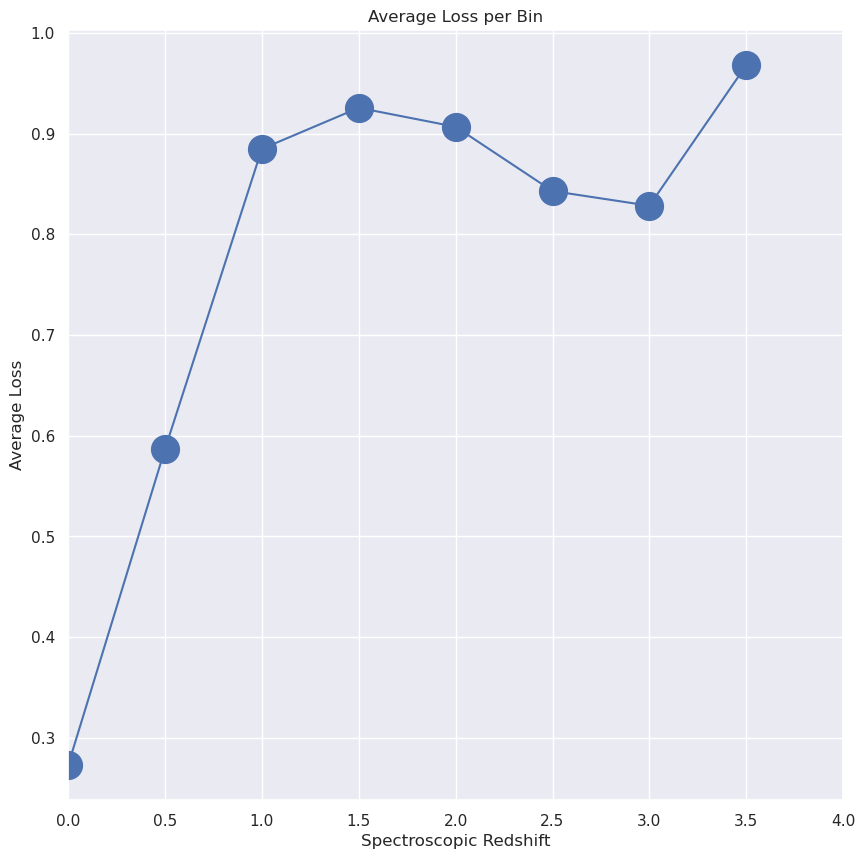

In [32]:
bins = np.arange(0, 4 + 0.5, 0.5)

# Assign each point to a bin
bin_indices = np.digitize(y_test_cvae, bins)

# Calculate average loss for each bin
average_losses = [loss_array_cvae[bin_indices == i].mean() for i in range(1, len(bins))]

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(bins[:-1], average_losses, '-o')  # -o for line plot with circles at data points
plt.title('Average Loss per Bin')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Average Loss')
plt.xlim([0, max(bins)])
plt.grid(True)
plt.show()

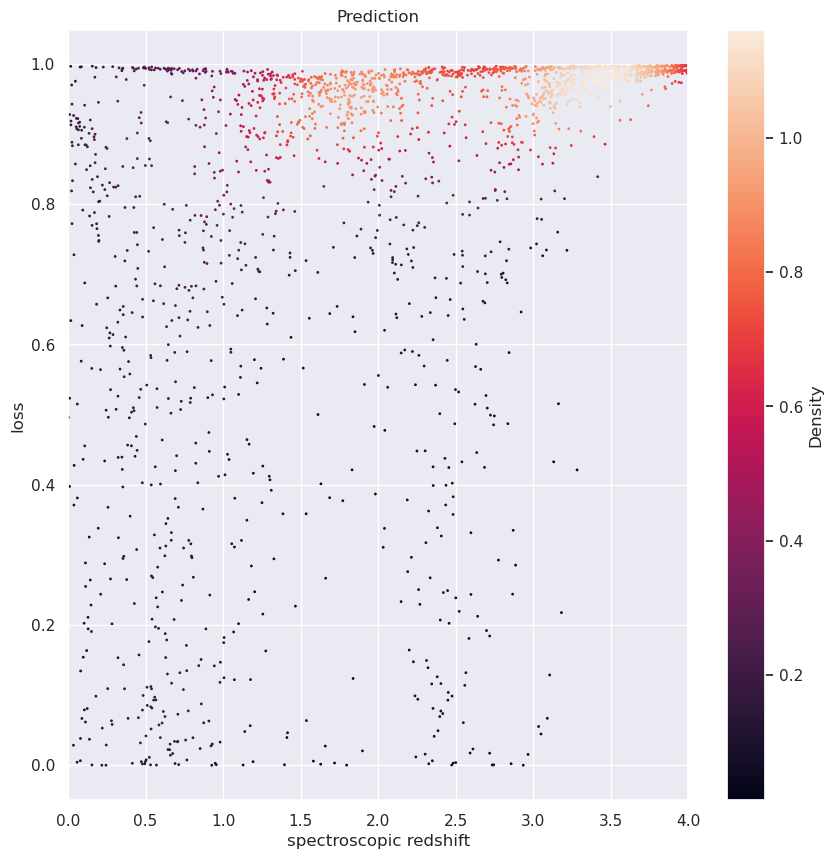

In [33]:
loss_array_ddpm = calculate_loss_individual(pred_ddpm[:,0], y_test_ddpm)

from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_ddpm, loss_array_ddpm])).astype('float32')
z_loss_ddpm = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_ddpm, loss_array_ddpm, c = z_loss_ddpm, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('loss')
# plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
# plt.ylim([0, z_max])
plt.show()

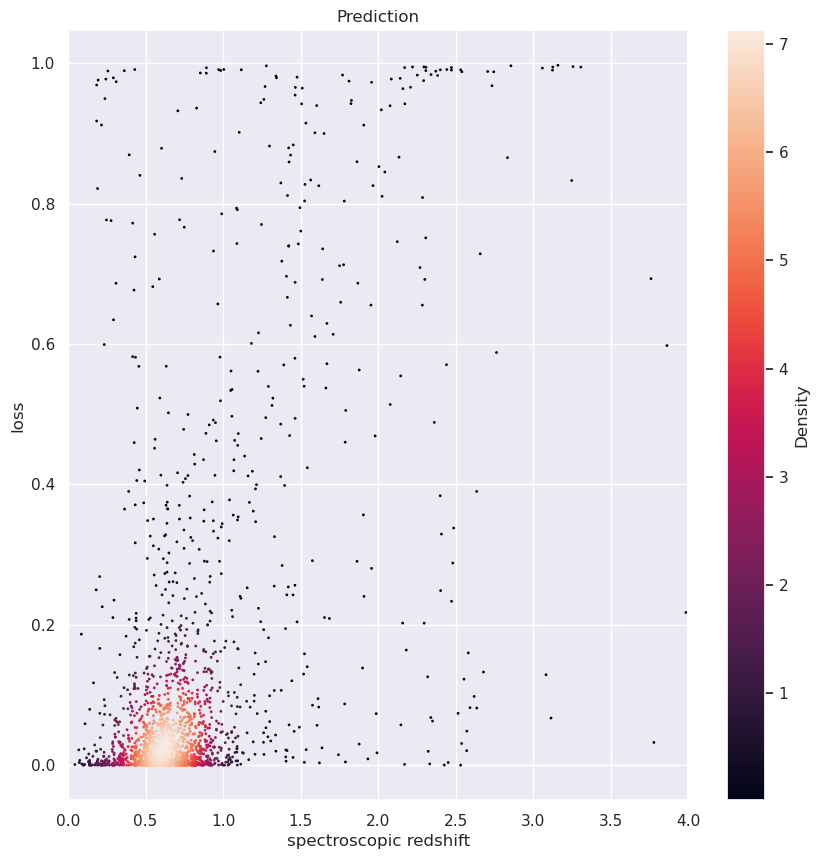

In [34]:
loss_array_real = calculate_loss_individual(pred_real[:,0], y_test_real)

from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_real, loss_array_real])).astype('float32')
z_loss_real = gaussian_kde(xy)(xy)

z_max = 4
sns.set(rc = {'figure.figsize' : (10, 10), 'lines.markersize' : 20})
plt.rcParams.update({'font.size' : 40})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_real, loss_array_real, c = z_loss_real, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('loss')
# plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
# plt.ylim([0, z_max])
plt.show()

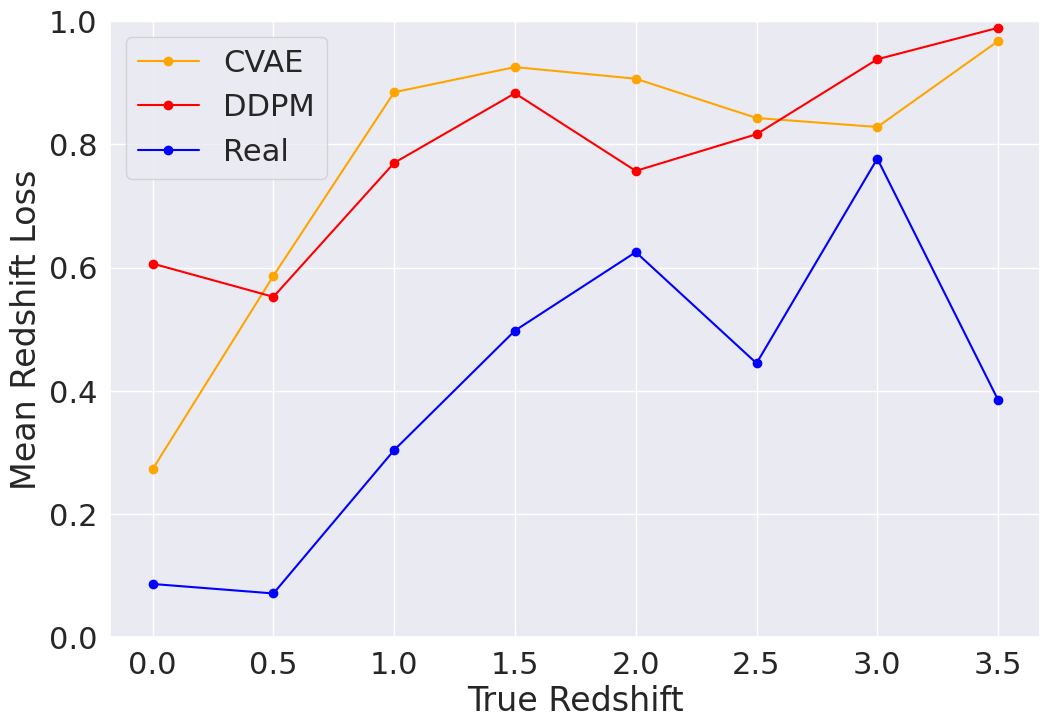

In [36]:
bin_indices_ddpm = np.digitize(y_test_ddpm, bins)

# Calculate average loss for each bin
average_losses_ddpm = [loss_array_ddpm[bin_indices_ddpm == i].mean() for i in range(1, len(bins))]

bin_indices_real = np.digitize(y_test_real, bins)

# Calculate average loss for each bin
average_losses_real = [loss_array_real[bin_indices_real == i].mean() for i in range(1, len(bins))]

sns.set(font_scale=2)
# Plotting both datasets
plt.figure(figsize=(12, 8))
plt.plot(bins[:-1], average_losses, marker='o', label='CVAE', color='orange')  # CVAE data
plt.plot(bins[:-1], average_losses_ddpm, marker='o', label='DDPM', color='red')  # DDPM data
plt.plot(bins[:-1], average_losses_real, marker='o', label='Real', color='blue')  # DDPM data
# plt.title('Mean Redshift Loss per Bin: CVAE vs. DDPM')
plt.xlabel('True Redshift')
plt.ylabel('Mean Redshift Loss')
plt.legend()

plt.ylim([0, 1])
plt.grid(True)

output_path = 'redshift_loss.png'
plt.savefig(output_path)
plt.show()

In [ ]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)